<img src="./images/banner.png" width="800">

# Random Forests: A Powerful Ensemble Method

Decision trees, while intuitive and interpretable, often suffer from high variance and a tendency to overfit. Random Forests address these limitations by introducing powerful ensemble techniques that maintain the interpretability of decision trees while significantly improving predictive performance. Let's explore this evolution and understand what makes Random Forests special.


Decision trees have several well-known limitations that can impact their performance in real-world applications:

1. **High Variance**
   - Individual trees are sensitive to small changes in the training data
   - Different splits of the data can produce very different trees
   - This instability can lead to poor generalization

2. **Overfitting**
   - Decision trees can easily overfit the training data
   - Trees trained on small datasets or with high complexity can produce highly specific models that don't generalize well


Random Forests, introduced by Leo Breiman in 2001, combine multiple decision trees in a way that reduces overfitting while maintaining the strong predictive capabilities of tree-based methods.


<img src="./images/random-forest.webp" width="600">

<img src="./images/decision-tree-vs-random-forest.png" width="600">

💡 **Key Insight:** Random Forests leverage two key ideas:
1. Building multiple decorrelated trees using bootstrap samples
2. Random feature selection at each split


The fundamental principle can be expressed mathematically as:

$f_{rf}(x) = \frac{1}{B}\sum_{b=1}^{B} f_b(x)$


Where:
- $f_{rf}(x)$ is the Random Forest prediction
- $B$ is the number of trees
- $f_b(x)$ is the prediction of the b-th tree


Random Forests introduce several innovative features that distinguish them from simple bagged decision trees:

1. **Random Feature Selection**
   - At each split, only a random subset of features is considered
   - For classification: typically $\sqrt{p}$ features are selected
   - For regression: typically $p/3$ features are selected
   where $p$ is the total number of features

2. **Tree Growth Strategy**
   - Trees are grown to maximum depth with no pruning
   - Each tree sees a different bootstrap sample

3. **Ensemble Properties**
   - Trees are grown independently, so it's a bagging method
   - Predictions are combined through voting (classification) or averaging (regression)

<img src="./images/bagging.png" width="800">

❗️ **Important Note:** The randomness in feature selection is what distinguishes Random Forests from simple bagging of decision trees. This additional source of randomness helps to decorrelate the trees, leading to better generalization.


The success of Random Forests can be attributed to several theoretical properties:

1. **Variance Reduction**
   - Multiple decorrelated trees reduce overall variance
   - The random feature selection ensures diversity among trees

2. **Bias-Variance Trade-off**
   - Deep individual trees maintain low bias
   - Averaging across trees reduces variance
   - The result is a better bias-variance trade-off than single trees

3. **Built-in Protection Against Overfitting**
   - Random feature selection acts as a form of regularization
   - Bootstrap sampling provides robustness to noise


**💡 Pro Tip:** The mathematical expectation of the variance reduction can be expressed as:

$$Var(average) = \rho \sigma^2 + \frac{1-\rho}{B}\sigma^2$$

Where:
- $\rho$ is the correlation between trees
- $\sigma^2$ is the variance of individual trees
- $B$ is the number of trees


This formula shows why reducing correlation between trees (through random feature selection) is crucial for the algorithm's success.

**Table of contents**<a id='toc0_'></a>    
- [Core Components of Random Forests](#toc1_)    
  - [Random Feature Selection](#toc1_1_)    
  - [Tree Diversity Mechanisms](#toc1_2_)    
  - [Voting/Averaging Strategies](#toc1_3_)    
  - [Out-of-Bag (OOB) Estimation](#toc1_4_)    
- [Feature Importance and Selection](#toc2_)    
  - [Understanding Feature Importance](#toc2_1_)    
  - [Using Feature Importance in Practice](#toc2_2_)    
  - [Visualizing Feature Importance](#toc2_3_)    
- [Hyperparameter Tuning](#toc3_)    
  - [Key Hyperparameters](#toc3_1_)    
  - [Practical Tuning Approach](#toc3_2_)    
  - [Monitoring and Validation](#toc3_3_)    
  - [Practical Guidelines](#toc3_4_)    
- [Implementation and Best Practices](#toc4_)    
  - [Loading and Preparing Data](#toc4_1_)    
  - [Basic Implementation](#toc4_2_)    
  - [Improved Implementation with Best Practices](#toc4_3_)    
  - [Feature Importance Analysis](#toc4_4_)    
  - [Performance Monitoring](#toc4_5_)    
  - [Best Practices Summary](#toc4_6_)    
- [Summary](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_'></a>[Core Components of Random Forests](#toc0_)

Random Forests achieve their remarkable performance through several fundamental components working together. Understanding these components is crucial for effectively implementing and tuning Random Forest models. Let's dive deep into each core mechanism that makes Random Forests work.


### <a id='toc1_1_'></a>[Random Feature Selection](#toc0_)


The hallmark of Random Forests is its unique approach to feature selection at each split. This mechanism ensures tree diversity and reduces the correlation between trees.


1. **Feature Sampling Process**
```python
def select_random_features(features, n_features_to_consider):
    """
    Randomly select features for splitting
    """
    total_features = len(features)
    n = min(n_features_to_consider, total_features)
    return np.random.choice(features, size=n, replace=False)
```


The number of features to consider ($m_{try}$) typically follows these guidelines:
- For classification: $m_{try} = \sqrt{p}$
- For regression: $m_{try} = p/3$
where $p$ is the total number of features


<img src="./images/random-forest-features.png" width="800">

💡 **Tip:** These are default values, but optimal $m_{try}$ can be found through cross-validation for your specific problem.


### <a id='toc1_2_'></a>[Tree Diversity Mechanisms](#toc0_)


Random Forests employ multiple strategies to ensure each tree in the forest is unique and contributes meaningful information to the ensemble.

1. **Bootstrap Sampling**
   - Each tree is trained on a bootstrap sample of size $n$ (same as original dataset)
   - Probability of a sample being selected: $P(selected) = 1 - (1 - \frac{1}{n})^n \approx 0.632$

2. **Tree Growing Process**
   - Each tree is grown to maximum depth with no pruning. Pruning is the process of reducing the size of decision trees by removing sections of the tree that provide little predictive power. Think of it like trimming a bush to prevent it from growing wild.

```
Before Pruning:                After Pruning:
       A                            A
     /   \                       /   \
    B     C                     B     C
   / \   / \                   /     / \
  D   E F   G                 D     F   G
 / \
H   I
```
```python
class RandomForestTree:
    def fit(self, X, y):
        # Bootstrap sampling
        bootstrap_indices = np.random.choice(len(X), size=len(X), replace=True)
        X_bootstrap = X[bootstrap_indices]
        y_bootstrap = y[bootstrap_indices]

        # Track out-of-bag samples
        self.oob_indices = np.setdiff1d(np.arange(len(X)), bootstrap_indices)

        # Grow tree with random feature selection at each split
        self.tree = self._grow_tree(X_bootstrap, y_bootstrap)
```


### <a id='toc1_3_'></a>[Voting/Averaging Strategies](#toc0_)


The way Random Forests combine predictions from individual trees is crucial for their performance:

1. **Classification Tasks**
   - Each tree votes for a class
   - Final prediction is the majority vote

   $\hat{y} = \text{mode}\{f_b(x) : b = 1,\ldots,B\}$

2. **Regression Tasks**
   - Each tree provides a numerical prediction
   - Final prediction is the average

   $\hat{y} = \frac{1}{B}\sum_{b=1}^{B}f_b(x)$


### <a id='toc1_4_'></a>[Out-of-Bag (OOB) Estimation](#toc0_)


OOB estimation is a unique feature of Random Forests that provides an unbiased estimate of the generalization error without requiring a separate validation set.

1. **OOB Error Calculation**
```python
def calculate_oob_error(forest, X, y):
    predictions = np.zeros((X.shape[0], forest.n_classes_))
    n_predictions = np.zeros(X.shape[0])

    for tree in forest.trees:
        # Get OOB samples for this tree
        oob_indices = tree.oob_indices

        # Predict for OOB samples
        pred = tree.predict_proba(X[oob_indices])
        predictions[oob_indices] += pred
        n_predictions[oob_indices] += 1

    # Average predictions
    with np.errstate(divide='ignore', invalid='ignore'):
        predictions /= n_predictions[:, np.newaxis]

    return predictions
```


❗️ **Important Note:** OOB error estimation is particularly valuable because:
- It's computed during training at no additional computational cost
- It provides an unbiased estimate of the test error
- It can be used for feature importance estimation


The mathematical formulation for OOB error is:

$E_{OOB} = \frac{1}{n}\sum_{i=1}^n L(y_i, \hat{f}_{OOB}(x_i))$

Where:
- $L$ is the loss function
- $\hat{f}_{OOB}(x_i)$ is the prediction for observation $i$ using only trees where $i$ was OOB


This built-in cross-validation mechanism is one of the most powerful features of Random Forests, as it provides reliable error estimates without the need for a separate validation set or cross-validation procedure.


The combination of these components creates a robust and effective ensemble learning method that:
- Reduces overfitting through averaging and random feature selection
- Provides reliable error estimates through OOB
- Maintains high prediction accuracy while being relatively simple to tune

## <a id='toc2_'></a>[Feature Importance and Selection](#toc0_)

Feature importance is one of the most valuable aspects of Random Forests, helping us understand which variables are most influential in making predictions. Let's explore how Random Forests help us identify and interpret important features.


### <a id='toc2_1_'></a>[Understanding Feature Importance](#toc0_)


Random Forests provide two main ways to measure feature importance:

1. **Gini Importance (Mean Decrease in Impurity)**
   - Measures how much each feature contributes to reducing impurity across all trees
   - Calculated automatically during training
   - Built into most Random Forest implementations

2. **Permutation Importance**
   - Measures how much model performance decreases when a feature is randomly shuffled
   - More intuitive and reliable, especially when features are correlated
   - Computationally more expensive


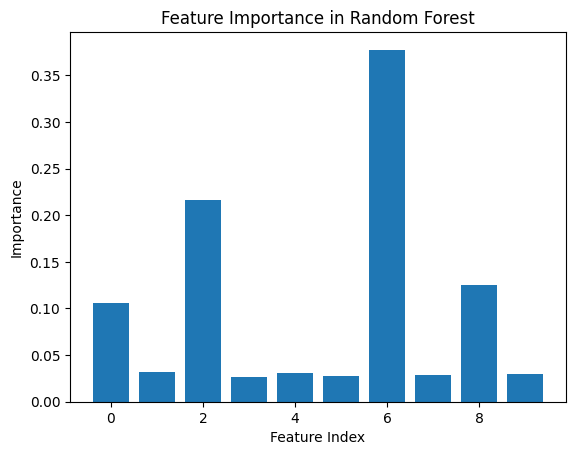

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
# Create sample dataset
X, y = make_classification(n_samples=1000, n_features=10, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importance
importance = rf.feature_importances_

plt.bar(range(len(importance)), importance)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.show()

💡 **Tip:** Feature importance values always sum to 1.0, making them easy to interpret as relative importance percentages.


### <a id='toc2_2_'></a>[Using Feature Importance in Practice](#toc0_)


Feature importance helps in several practical ways:

1. **Feature Selection**
   - Identify and remove irrelevant features
   - Reduce model complexity
   - Improve model performance


```python
# Select top K most important features
def select_top_features(X, importance, k=5):
    # Get indices of top K features
    top_features = importance.argsort()[-k:][::-1]

    # Return selected features
    return X[:, top_features]
```


2. **Model Interpretation**
   - Understand which features drive predictions
   - Explain model decisions to stakeholders
   - Validate model behavior


❗️ **Important Note:** High feature importance doesn't always mean causation. It only indicates predictive power within the model.


### <a id='toc2_3_'></a>[Visualizing Feature Importance](#toc0_)


Visualization makes feature importance more interpretable:


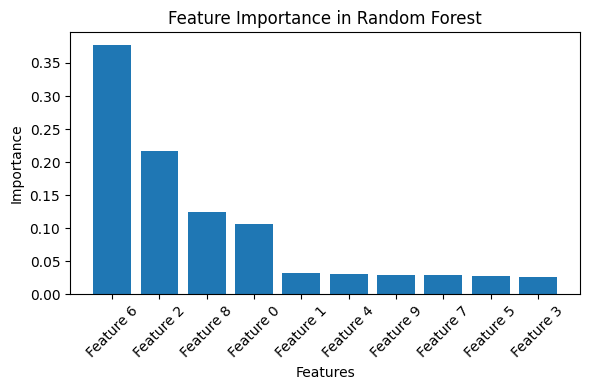

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance(importance, feature_names=None):
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(len(importance))]

    # Sort importance in descending order
    indices = np.argsort(importance)[::-1]

    plt.figure(figsize=(6, 4))
    plt.bar(range(len(importance)), importance[indices])
    plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=45)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance in Random Forest')
    plt.tight_layout()
    plt.show()

plot_feature_importance(importance)

This simple visualization helps to:
- Quickly identify most important features
- Compare relative importance between features
- Communicate results to non-technical audiences


Understanding feature importance helps you:
- Focus on collecting better data for important features
- Simplify your model by removing unimportant features
- Gain insights about your problem domain
- Build more trustworthy and interpretable models


Remember that feature importance should be used alongside domain knowledge and careful validation to make the best decisions about your model.

## <a id='toc3_'></a>[Hyperparameter Tuning](#toc0_)


While Random Forests work well with default parameters, proper tuning can significantly improve their performance. Let's explore the key hyperparameters and how to tune them effectively.


### <a id='toc3_1_'></a>[Key Hyperparameters](#toc0_)


Let's focus on the most important hyperparameters that typically have the largest impact on model performance:

1. **n_estimators**: Number of trees in the forest
   - More trees generally lead to better performance but increase computation time
   - Usually, performance stabilizes after a certain number of trees
   ```python
   # Example of impact of n_estimators
   from sklearn.ensemble import RandomForestClassifier
   from sklearn.model_selection import cross_val_score

   scores = []
   for n in [10, 50, 100, 200, 500]:
       rf = RandomForestClassifier(n_estimators=n, random_state=42)
       score = cross_val_score(rf, X, y, cv=5).mean()
       scores.append(score)
   ```

2. **max_depth**: Maximum depth of each tree
   - Controls how deep each tree can grow
   - Deeper trees can capture more complex patterns but may overfit
   - Consider leaving it as None and controlling complexity with min_samples_split instead


3. **min_samples_split**: Minimum samples required to split a node
   - Higher values prevent splitting small groups of samples
   - Helps control overfitting
   - Default is 2, but increasing it can help with noisy data


💡 **Tip:** Start with default parameters and adjust based on cross-validation scores and computational constraints.


### <a id='toc3_2_'></a>[Practical Tuning Approach](#toc0_)


Here's a systematic approach to tuning Random Forests:


```python
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

# Create Random Forest model
rf = RandomForestClassifier(random_state=42)

# Perform grid search
grid_search = GridSearchCV(
    rf, param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1  # Use all available cores
)

# Fit grid search
grid_search.fit(X, y)

# Best parameters
print("Best parameters:", grid_search.best_params_)
```


❗️ **Important Note:** Grid search can be computationally expensive. Start with a coarse grid and refine around promising values.


### <a id='toc3_3_'></a>[Monitoring and Validation](#toc0_)


Always validate your tuning process:

1. **Learning Curves**
```python
def plot_learning_curves(X, y, model):
    train_sizes, train_scores, valid_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5, n_jobs=-1
    )

    plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
    plt.plot(train_sizes, valid_scores.mean(axis=1), label='Cross-validation score')
    plt.xlabel('Training set size')
    plt.ylabel('Score')
    plt.legend()
    plt.show()
```


2. **Common Pitfalls to Avoid**
   - Overfitting to validation set through excessive tuning
   - Ignoring computational costs
   - Focusing too much on small performance improvements


### <a id='toc3_4_'></a>[Practical Guidelines](#toc0_)


Here are some practical guidelines for tuning Random Forests:

1. **Start Simple**
   - Begin with default parameters
   - Evaluate performance
   - Identify bottlenecks (bias vs. variance)

2. **Systematic Tuning**
   ```python
   # Example of systematic tuning approach
   def systematic_tune(X, y):
       # 1. Start with baseline
       baseline = RandomForestClassifier().fit(X, y)
       baseline_score = cross_val_score(baseline, X, y, cv=5).mean()

       # 2. Tune n_estimators
       # 3. Tune tree complexity (max_depth or min_samples_split)
       # 4. Fine-tune other parameters
       return best_model
   ```

3. **Performance vs. Complexity Trade-offs**
   - Consider computational resources
   - Think about model deployment requirements
   - Balance accuracy with training/inference time


Remember:
- Not all parameters need tuning
- Small improvements might not be worth the computational cost
- Cross-validation is crucial for reliable tuning
- Monitor both training and validation performance


By following these guidelines, you can effectively tune your Random Forest models while avoiding common pitfalls and unnecessary complexity.

## <a id='toc4_'></a>[Implementation and Best Practices](#toc0_)

Let's explore how to implement Random Forests effectively using the popular breast cancer dataset. We'll cover best practices and common pitfalls while working through a practical example.


### <a id='toc4_1_'></a>[Loading and Preparing Data](#toc0_)


First, let's load and prepare our data:


In [8]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

# Load the breast cancer dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (455, 30)
Test set shape: (114, 30)


### <a id='toc4_2_'></a>[Basic Implementation](#toc0_)


Let's start with a basic Random Forest implementation and gradually improve it:


In [10]:
# Basic implementation
rf_basic = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

# Fit the model
rf_basic.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [11]:
# Make predictions
y_pred = rf_basic.predict(X_test)

# Check accuracy
print(f"Basic model accuracy: {rf_basic.score(X_test, y_test):.3f}")

Basic model accuracy: 0.965


💡 **Tip:** Always set random_state for reproducibility during development.


### <a id='toc4_3_'></a>[Improved Implementation with Best Practices](#toc0_)


Here's a more comprehensive implementation incorporating several best practices:


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Create a pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('rf', RandomForestClassifier(
        n_estimators=100,
        min_samples_leaf=2,
        max_features='sqrt',
        n_jobs=-1,  # Use all CPU cores
        random_state=42
    ))
])

# Fit pipeline
rf_pipeline.fit(X_train, y_train)

# Evaluate with cross-validation
cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

Cross-validation scores: 0.954 (+/- 0.029)


### <a id='toc4_4_'></a>[Feature Importance Analysis](#toc0_)


Understanding feature importance is crucial for model interpretation:


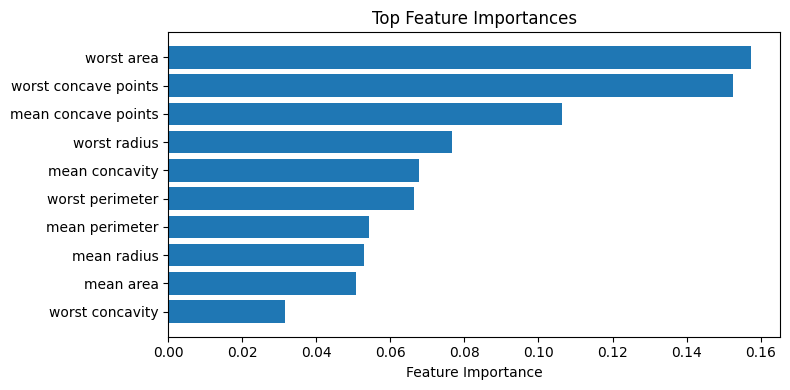

In [25]:
def plot_top_features(pipeline, feature_names, top_n=10):
    # Get feature importances and indices
    importances = pipeline.named_steps['rf'].feature_importances_
    indices = np.argsort(importances)[-top_n:]

    plt.figure(figsize=(8, 4))
    plt.barh(range(top_n), importances[indices])
    plt.yticks(range(top_n), [feature_names[i] for i in indices])

    plt.xlabel('Feature Importance')
    plt.title('Top Feature Importances')
    plt.tight_layout()

# Plot top features
plot_top_features(rf_pipeline, data.feature_names)


❗️ **Important Note:** Feature importance can help identify which medical measurements are most crucial for diagnosis in this case.


### <a id='toc4_5_'></a>[Performance Monitoring](#toc0_)


Monitor your model's performance across different metrics:



Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



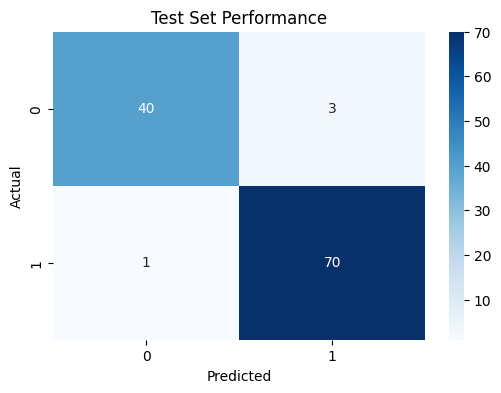

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(pipeline, X, y, title="Model Evaluation"):
    y_pred = pipeline.predict(X)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Evaluate on test set
evaluate_model(rf_pipeline, X_test, y_test, "Test Set Performance")

### <a id='toc4_6_'></a>[Best Practices Summary](#toc0_)


1. **Data Preprocessing**
   - Scale features when they're on different scales
   - Handle missing values (if any)
   - Consider feature engineering


2. **Model Configuration**
   ```python
   # Example of well-configured model
   rf_well_configured = RandomForestClassifier(
       n_estimators=100,
       min_samples_leaf=2,
       max_features='sqrt',
       n_jobs=-1,
       random_state=42,
       oob_score=True  # Enable out-of-bag score estimation
   )
   ```


3. **Performance Validation**
   ```python
   # Check for overfitting
   print(f"Training score: {rf_pipeline.score(X_train, y_train):.3f}")
   print(f"Test score: {rf_pipeline.score(X_test, y_test):.3f}")
   ```


4. **Prediction Probabilities**
   ```python
   # Get probability predictions
   probabilities = rf_pipeline.predict_proba(X_test)

   # Look at probability distribution for first few samples
   print("\nPrediction probabilities for first 5 samples:")
   print(pd.DataFrame(probabilities[:5], columns=['Class 0', 'Class 1']))
   ```


Remember these key points:
- Use pipelines for reproducible workflows
- Monitor both training and test performance
- Consider computational resources
- Enable out-of-bag scoring when possible
- Use cross-validation for reliable performance estimates
- Look at multiple performance metrics


By following these practices, you can build more reliable and maintainable Random Forest models while avoiding common implementation pitfalls.

## <a id='toc5_'></a>[Summary](#toc0_)

Random Forests are a powerful and versatile ensemble learning method that combines multiple decision trees to create a robust and accurate model. Let's recap the key points:

- Random Forests improve upon single decision trees by:
  - Using multiple trees (typically 100 or more)
  - Introducing randomness through bootstrap sampling
  - Considering random subsets of features at each split


Here are the main advantages of Random Forests:
1. **Robust Performance**
   - Works well on most datasets without extensive tuning
   - Handles both numerical and categorical features
   - Resistant to overfitting

2. **Built-in Features**
   - Feature importance rankings
   - Out-of-bag error estimation
   - Handles missing values well

3. **Practical Benefits**
   - Parallel processing capability
   - Few hyperparameters to tune
   - No feature scaling required


You may be wondering when to use Random Forests:
- Classification or regression tasks
- When interpretability is important but not crucial
- When you have sufficient computational resources
- When you need reliable feature importance measures


❗️ **Important Note:** While powerful, Random Forests might not be the best choice when:
- You need a very simple, fully interpretable model
- You're working with very high-dimensional sparse data
- You have strict latency requirements in production


Remember: Random Forests combine simplicity, power, and interpretability, making them an excellent default choice for many machine learning problems.